In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def get_boundary(mask, thicky=8):
    # tmp = mask.data.numpy().astype('uint8')
    tmp = mask
    contour, _ = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boundary = np.zeros_like(tmp)
    boundary = cv2.drawContours(boundary, contour, -1, 1, thicky)
    boundary = boundary.astype(float)
    return boundary

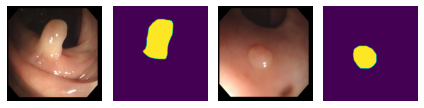

In [4]:
image_path = "/media/ssd/syz/Polyp-PVT/dataset/TestDataset/CVC-300/images/149.png"
mask_path = "/media/ssd/syz/Polyp-PVT/dataset/TestDataset/CVC-300/masks/149.png"
image1_path = "/media/ssd/syz/Polyp-PVT/dataset/TestDataset/CVC-300/images/180.png"
mask1_path = "/media/ssd/syz/Polyp-PVT/dataset/TestDataset/CVC-300/masks/180.png"

image = Image.open(image_path).convert('RGB').resize((352,352),Image.BILINEAR)
mask = Image.open(mask_path).convert('L').resize((352,352),Image.BILINEAR)
image1 = Image.open(image1_path).convert('RGB').resize((352,352),Image.BILINEAR)
mask1 = Image.open(mask1_path).convert('L').resize((352,352),Image.BILINEAR)

fig, axs = plt.subplots(1,4,)
axs[0].imshow(image)
axs[0].axis('off')
axs[1].imshow(mask)
axs[1].axis('off')
axs[2].imshow(image1)
axs[2].axis('off')
axs[3].imshow(mask1)
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [7]:
arrimage = np.array(image)
arrimage1 = np.array(image1)

arrmask = np.array(mask)
arrmask1 = np.array(mask1)

arrinp = np.stack([arrimage, arrimage1], axis=0)
arrmask = np.stack([arrmask, arrmask1], axis=0)

t_inp = torch.from_numpy(arrinp/255).float().permute(0,3,1,2)
t_mask = torch.from_numpy(arrmask).long()

print(t_inp.shape, t_mask.shape, t_inp.type(), t_mask.type())

torch.Size([2, 3, 352, 352]) torch.Size([2, 352, 352]) torch.FloatTensor torch.LongTensor


In [8]:
b, c, h, w = t_inp.shape
print(b, c, h, w, h*w)

2 3 352 352 123904


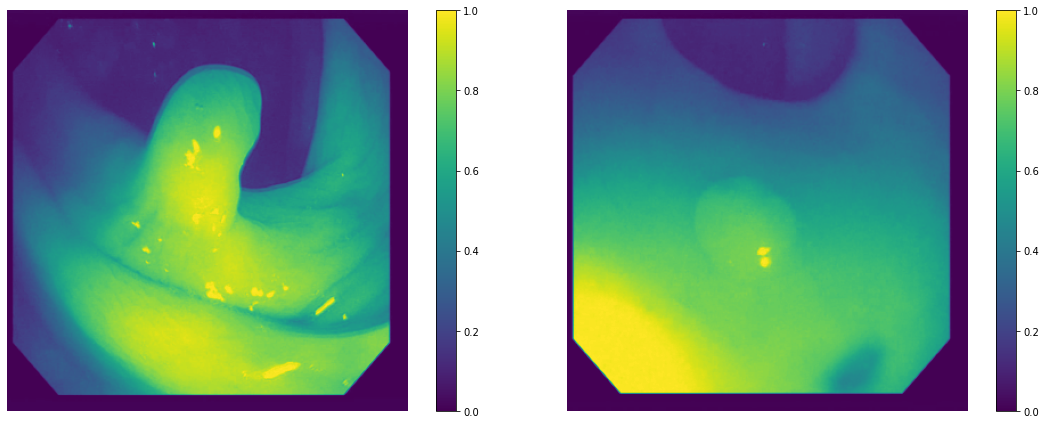

In [9]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

im0 = axs[0].imshow(t_inp[0,0,...].view(h, w).data.numpy())
axs[0].axis('off')
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(t_inp[1,0,...].view(h, w).data.numpy())
axs[1].axis('off')
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

In [66]:
# def ohem_bceloss( pred, target, rate=0.7 ):
#     if pred.ndim == 4:
#         pred = pred.squeeze(1)
#     b, h, w = pred.shape
#     prob = torch.sigmoid(pred)
#     bce_loss = F.binary_cross_entropy(prob, target, reduction='none')
#     flatten_bce_loss = bce_loss.contiguous().view(b, -1)
#     sorted_flatten_bce_loss, idx = torch.sort(flatten_bce_loss, dim=1, descending=True) #降序
#     print(sorted_flatten_bce_loss.shape)
#     keep_num = min(flatten_bce_loss.size()[1], int(h*w*rate))
#     # discarded_num = h*w - keep_num
#     # print(discarded_num)
#     if keep_num < flatten_bce_loss.size()[1]:
#         keep_idx_cuda = idx[:, :keep_num]
#         # create
#         mask = torch.zeros(b, h*w)
#         mask.scatter_(dim=1, index=keep_idx_cuda, src=torch.ones_like(mask))
#         # ohem_loss =  torch.gather(sorted_flatten_bce_loss, dim=1, index=keep_idx_cuda)
#         ohem_loss = flatten_bce_loss*mask
#     loss = ohem_loss.mean()
#     return loss, keep_idx_cuda

In [11]:
# def ohem_bceloss( pred, target, rate=0.7, ):
#     if pred.ndim == 4:
#         pred = pred.squeeze(1)
#     b, h, w = pred.shape
#     prob = torch.sigmoid(pred)
#     loss = F.binary_cross_entropy(prob, target, reduction='none')
#     if rate != 1.0:
#         loss = loss.contiguous().view(b, -1)
#         _, idx = torch.sort(loss, dim=1, descending=True) #降序
#         keep_num = int(h*w*rate)
#         keep_idx_cuda = idx[:, :keep_num]
#         # construct weight mask
#         mask = torch.zeros_like(loss)
#         mask.scatter_(dim=1, index=keep_idx_cuda, src=torch.ones_like(mask))
#         loss = loss*mask
#         # loss =  torch.gather(loss, dim=1, index=keep_idx_cuda)
#     loss = loss.mean()
#     return loss, keep_idx_cuda

In [12]:
def ohem_bceloss( pred, target, rate=0.7 ):
    if pred.ndim == 4:
        pred = pred.squeeze(1)
    b, h, w = pred.shape
    prob = torch.sigmoid(pred)
    loss = F.binary_cross_entropy(prob, target, reduction='none')
    if rate != 1.0:
        loss = loss.contiguous().view(b, -1)
        _, idx = torch.sort(loss, dim=1, descending=True) #降序
        keep_num = int(h*w*rate)
        discarded_idx = idx[:,keep_num:]
        # construct weight mask
        mask = torch.zeros_like(loss)
        loss.scatter_(dim=1, index=discarded_idx, src=mask)
    loss = loss.mean()
    return loss, discarded_idx

In [13]:
class minimodel(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(minimodel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool1 = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)

        self.middle = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )

        self.up1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        self.up2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
            )
        
        self.final = nn.Conv2d(16, out_channels, 3, stride=1, padding=1)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)

        x = self.middle(x)

        x = self.up1(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = self.up2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = self.final(x)
        
        return x

if __name__ == "__main__":
    
    gradients = {}
    def get_gradients(name):
        def backward_hook(module, grad_in, grad_out):
            gradients[name] = (grad_out[0].detach())
        return backward_hook
    
    model = minimodel()
    model.final.register_backward_hook(get_gradients('final'))

    model.train()
    pred = model(t_inp)
    print(pred.shape)
    # loss = F.binary_cross_entropy_with_logits(pred.squeeze(1), t_mask.float())
    loss, dis_idx = ohem_bceloss(pred, t_mask.float())
    loss.backward()

/home/jim/miniconda3/envs/pytorch-su3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/jim/miniconda3/envs/pytorch-su3/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([2, 1, 352, 352])


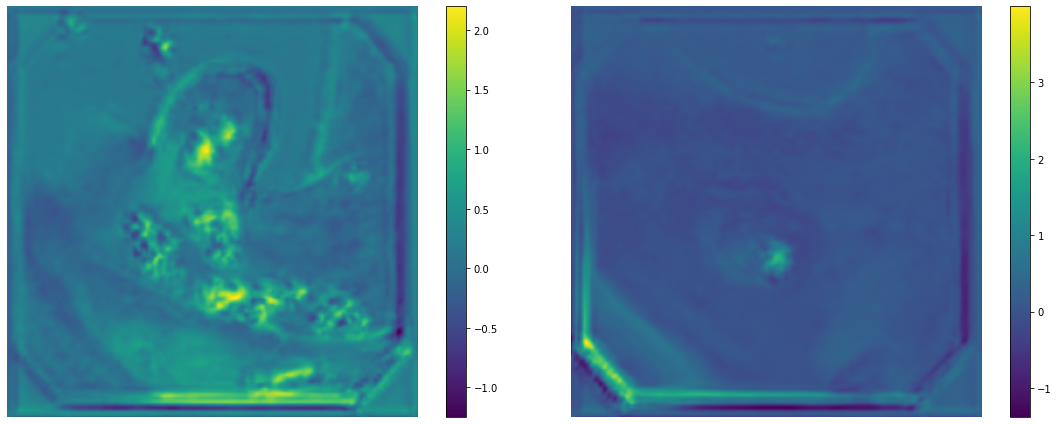

In [14]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

im0 = axs[0].imshow(pred[0,0,...].view(h, w).data.numpy())
axs[0].axis('off')
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(pred[1,0,...].view(h, w).data.numpy())
axs[1].axis('off')
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

In [16]:
dis_idx.shape

torch.Size([2, 37172])

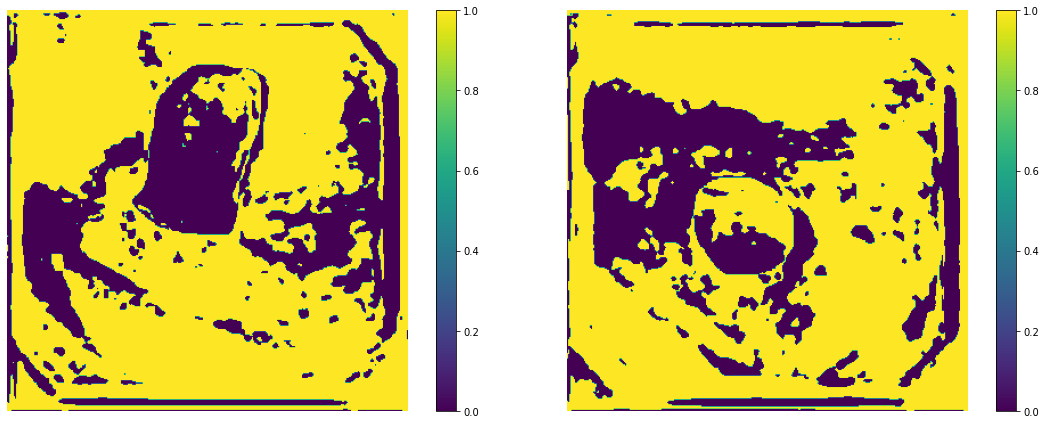

In [20]:
tmp = torch.ones(b,h*w)
output = tmp.scatter(dim=1, index=dis_idx, src=torch.zeros_like(tmp))

fig, axs = plt.subplots(1,2,figsize=(16,6))

im0 = axs[0].imshow(output[0,:].view(h,w).data.numpy())
axs[0].axis('off')
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(output[1,:].view(h,w).data.numpy())
axs[1].axis('off')
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

In [47]:
gradients['final'].shape

torch.Size([2, 1, 352, 352])

In [79]:
reshape_grads = gradients['final'].unsqueeze(1).view(b, h*w)
index = torch.where(reshape_grads==0)
print(f"index: {index}")
index = torch.stack((index[1][index[0]==0], index[1][index[0]==1]), dim=0)
print(index.shape)

index: (tensor([0, 0, 0,  ..., 1, 1, 1]), tensor([   750,    751,    752,  ..., 123897, 123898, 123899]))
torch.Size([2, 37172])


torch.Size([2, 123904])


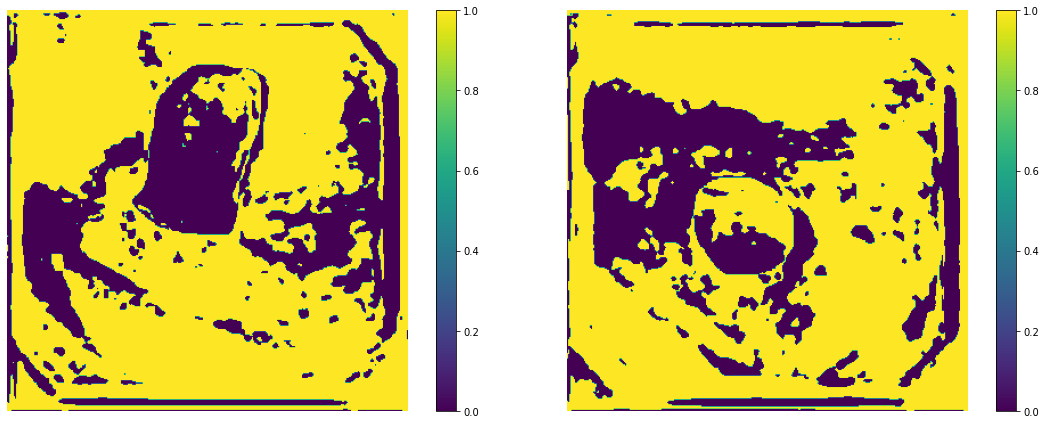

In [75]:
tmp = torch.ones_like(reshape_grads)
output = tmp.scatter(dim=1, index=index, src=torch.zeros_like(tmp))
print(output.shape)

fig, axs = plt.subplots(1,2,figsize=(16,6))

im0 = axs[0].imshow(output[0,:].view(h,w).data.numpy())
axs[0].axis('off')
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(output[1,:].view(h,w).data.numpy())
axs[1].axis('off')
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()